# Metropolis-Hastings 05

#### Josep Fortiana 2018-11-28

## Exercise 5

#### Modeling Data with Cauchy Errors

Example in Jim Albert (2009), _Bayesian Computation with R, 2nd ed.,_ Section 6.9. 

In this example we study a famous dataset by Charles Darwin (1876), _The Effects of Cross- and Self-fertilisation in the Vegetable Kingdom,_ resulting from an experiment to examine the superiority of cross-fertilized plants over self-fertilized plants. $n=15$ pairs of plants were used. Each pair consisted of one cross-fertilized plant and one self-fertilized plant which germinated at the same time and grew in the same pot. The plants were measured at a fixed time after planting and the difference in heights between the cross- and self-fertilized plants are recorded in eighths of an inch. 

In [29]:
require(LearnBayes)
data(darwin)
diff<-darwin$difference
diff
n<-length(diff)

[1] -67 -48   6   8  14  16  23  24  28  29  41  49  67  60  75

#### Descriptive statistics

From another source (The `BSDA` package) it is possible to get the original data. There are two outliers, which prevent a gaussian model for this data. We use, instead, a Cauchy model.


	Shapiro-Wilk normality test

data:  Diff
W = 0.90079, p-value = 0.09785


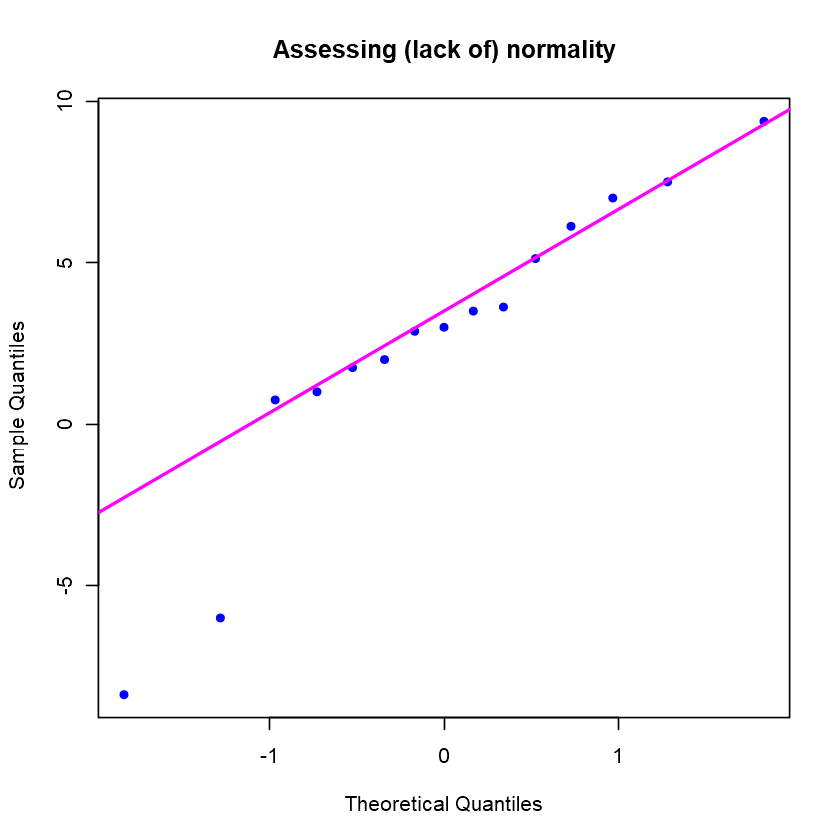

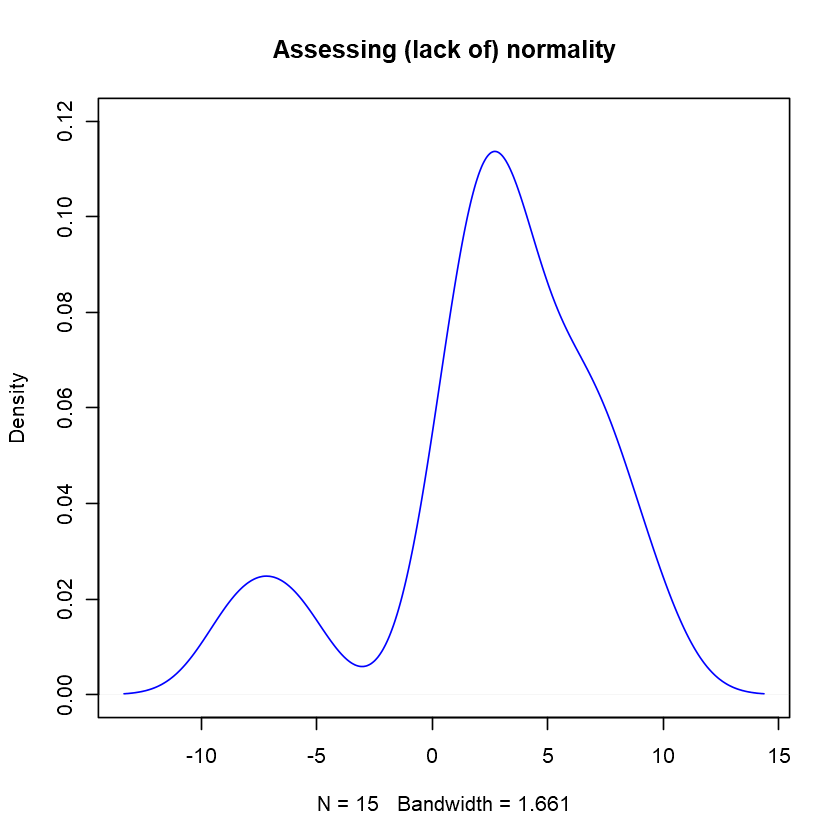

In [28]:
Cross<-c(23.500,12.000,21.000,22.000,19.125,21.500,22.125,20.375,18.250,21.625,23.250,21.000,
    22.125,23.000,12.000)
Self<-c(17.375,20.375,20.000,20.000,18.375,18.625,18.625,15.250,16.500,18.000,16.250,18.000,
    12.750,15.500,18.000)
Diff<- Cross-Self  # diff in the LearnBayes package is 8*Diff
qqnorm(Diff,pch=19,col="blue",cex=0.7,main = "Assessing (lack of) normality")
qqline(Diff,lwd=2.0,col="magenta")
shapiro.test(Diff)
plot(density(Diff), ylim = c(0, 0.12), col="blue",main = "Assessing (lack of) normality")

#### Model for the difference data. Likelihood

The model is with a Cauchy pdf, with location parameter $\mu$ and scale parameter $\sigma$:

$$
    f(y\,|\,\mu,\sigma)=\dfrac{1}{\pi\,\sigma\,(1 + z^2)},
$$

where $z=(x−\mu)/\sigma$. The likelihood for the dataset is the product:

$$
    \cal{L}(y\,|\,\mu,\sigma) = \prod_{i=1}^{n}f(y_i\,|\,\mu,\sigma)
$$

#### Prior pdf

We assign the usual noninformative prior to $(\mu,\sigma)$:

$$
    g(μ, σ) \propto \dfrac{1}{\sigma}.
$$

#### Posterior pdf and parameter transformation

The posterior pdf is given, up to a proportionality constant, by:

$$
\renewcommand{\arraystretch}{2.1}\begin{array}{lcl}
    g(\mu,\sigma\,|\,\text{data})&\propto &\dfrac{1}{\sigma}\,
    \displaystyle\prod_{i=1}^{n}f(y_i\,|\,\mu,\sigma)\\
    &=&\dfrac{1}{\sigma}\,\displaystyle\prod_{i=1}^{n}
    \left[\dfrac{1}{\sigma}\,\left(1+\dfrac{(y_i-\mu)^2}{\sigma^2}\right)^{-1}\right].
\end{array}
$$

Again we first transform the positive parameter $\sigma$ to the real line using $\lambda = \log\sigma$, 
leading to the posterior density of $(\mu,\lambda)$:

$$
  g(\mu,\lambda\,|\,\text{data})\propto
    \prod_{i=1}^{n}\left[\exp(−\lambda)\,
    \left(1+\exp(−2\lambda)(y_i−\mu)^2\right)^{-1}\right].
$$

#### Log-posterior 

The logarithm of the posterior pdf is:

$$
  \log g(\mu,\lambda\,|\,\text{data}) =
    \sum_{i=1}^{n}\left[−\lambda -\log\left(1+\exp(−2\lambda)(y_i−\mu)^2\right)\right].
$$

This pdf is implemented as the `cauchyerrorpost` function in the `LearnBayes` package (recall that "Cauchy distribution" is another name for a Student's $t$ with 1 degree of freedom). This function takes two arguments, the `data` vector and `theta`, a vector with the two components, $\mu$ and $\lambda$:

```
cauchyerrorpost<-function (theta, data){
    logf<-function(data, theta) log(dt((data - theta[1])/exp(theta[2]),df = 1)/exp(theta[2]))
    return(sum(logf(data, theta)))
}
```

#### Laplace approximation

We use again the empirical moment estimates as initial value for the posterior mode computation.

In [30]:
m.diff<-mean(diff)
sd.diff<-sd(diff)
lambda.diff<-log(sd.diff)
round(m.diff,3)
round(sd.diff,3)
round(lambda.diff,3)

[1] 21.667

[1] 38.572

[1] 3.653

In [31]:
darwin.fit<-laplace(cauchyerrorpost, c(m.diff,lambda.diff), diff)
darwin.fit

34.9618773,0.3659712
0.3659712,0.1378026


#### Bounding rectangle

The standard deviations at the mode are the square roots of the diagonal entries in the variance-covariance matrix. We construct a rectangle around the mode, plus and minus about four or five standard deviations. We can assume that such rectangle will contain almost all of the posterior probability. 

In [33]:
rectangle.low<-darwin.fit$mode-4*sqrt(diag(darwin.fit$var))
rectangle.hi<-darwin.fit$mode+4*sqrt(diag(darwin.fit$var))
round(rectangle.low,3)
round(rectangle.hi,3)

[1] 1.043 1.288

[1] 48.346  4.258

Finally, after some trial and error, we use the rectangle $\mu\in(-10,60)$, $\lambda\in(1,4.5)$ as the bounding rectangle for plotting the posterior pdf contour plot.

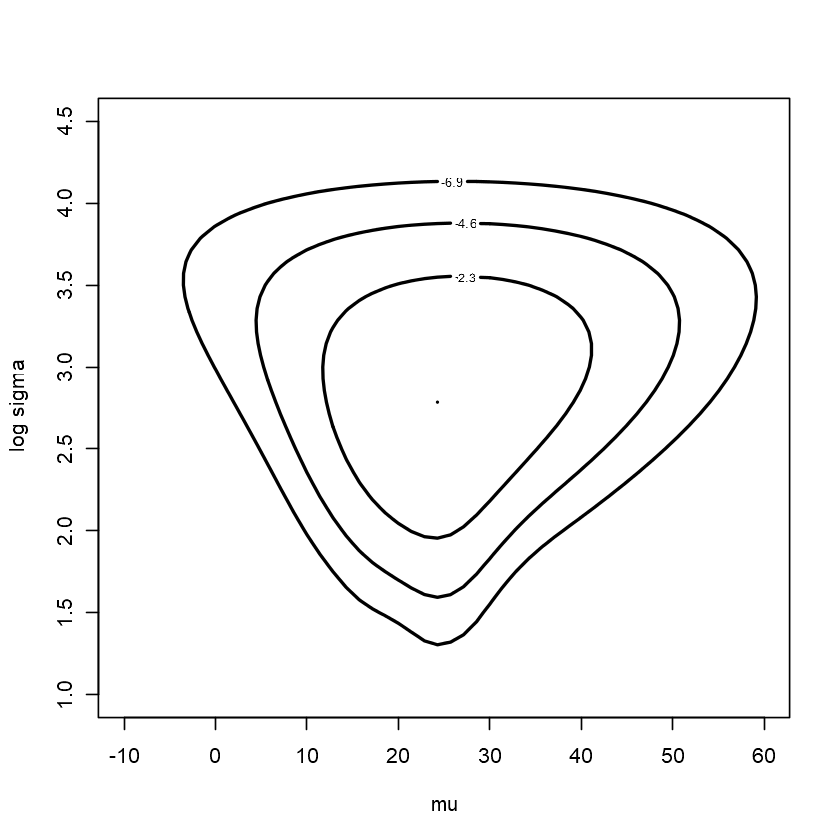

In [34]:
mycontour(cauchyerrorpost,c(-10,60,1,4.5),diff,xlab="mu",ylab="log sigma")

Contour plot of a bivariate normal pdf with the same mode and variance-covariance as the posterior pdf

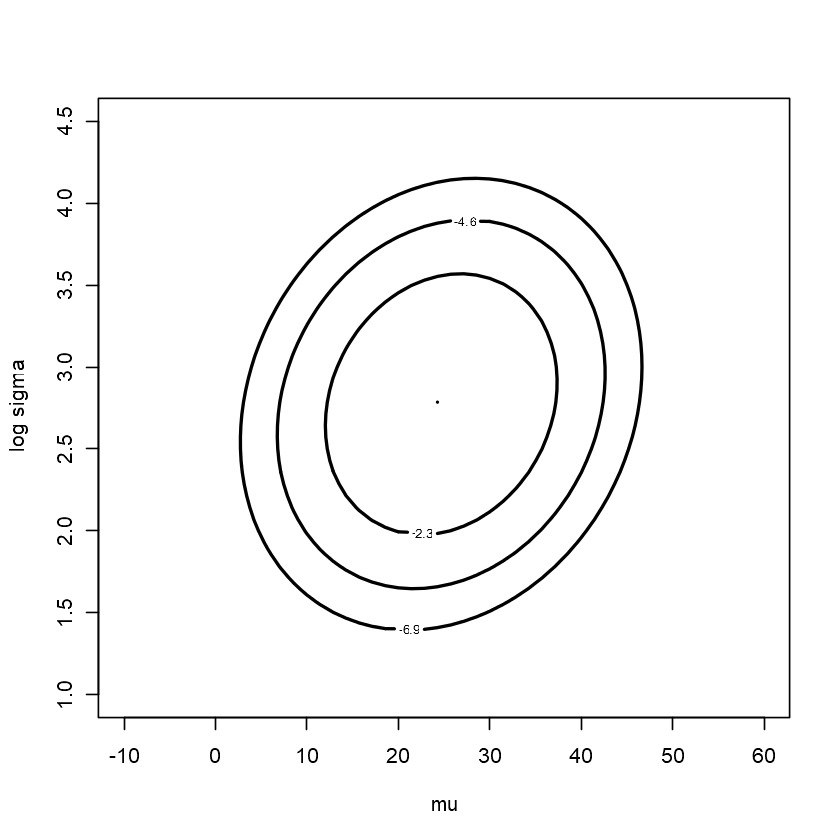

In [35]:
mycontour(lbinorm,c(-10,60,1,4.5),list(m=darwin.fit$mode,v=darwin.fit$var),xlab="mu",ylab="log sigma")

#### Metropolis algorithm

In [36]:
proposal=list(var=darwin.fit$var,scale=2.5)
start=c(20,3)
m=1000
s=rwmetrop(cauchyerrorpost,proposal,start,m,diff)

Plot the chain points on the contour plot

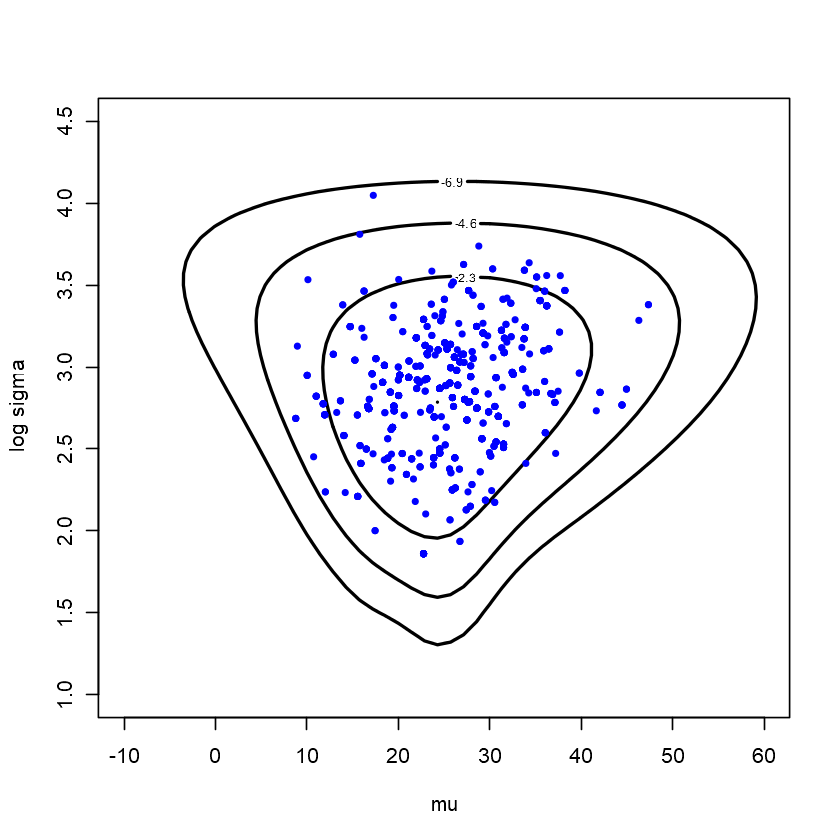

In [37]:
mycontour(cauchyerrorpost,c(-10,60,1,4.5),diff,xlab="mu",ylab="log sigma")
points(s$par[,1],s$par[,2],pch=19,col="blue",cex=0.5)